In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import torch
import transformers
import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)



logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-05-27 11:26:38 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-05-27 11:26:40 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100-SXM4-80GB'
2025-05-27 11:26:40 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
from src.utils.training_utils import get_device_map
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

device_map = get_device_map(model_key, 30, n_gpus=8)
device_map

2025-05-27 11:26:42 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-27 11:26:42 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-27 11:26:42 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-05-27 11:26:42 wandb.docker.auth DEBUG    No config file found


{'model.embed_tokens': 7,
 'model.norm': 7,
 'model.rotary_emb': 7,
 'lm_head': 7,
 'model.layers.0': 0,
 'model.layers.1': 1,
 'model.layers.2': 2,
 'model.layers.3': 3,
 'model.layers.4': 4,
 'model.layers.5': 5,
 'model.layers.6': 6,
 'model.layers.7': 7,
 'model.layers.8': 0,
 'model.layers.9': 1,
 'model.layers.10': 2,
 'model.layers.11': 3,
 'model.layers.12': 4,
 'model.layers.13': 5,
 'model.layers.14': 6,
 'model.layers.15': 7,
 'model.layers.16': 0,
 'model.layers.17': 1,
 'model.layers.18': 2,
 'model.layers.19': 3,
 'model.layers.20': 4,
 'model.layers.21': 5,
 'model.layers.22': 6,
 'model.layers.23': 7,
 'model.layers.24': 0,
 'model.layers.25': 1,
 'model.layers.26': 2,
 'model.layers.27': 3,
 'model.layers.28': 4,
 'model.layers.29': 5,
 'model.layers.30': 0,
 'model.layers.31': 1,
 'model.layers.32': 2,
 'model.layers.33': 3,
 'model.layers.34': 4,
 'model.layers.35': 5,
 'model.layers.36': 6,
 'model.layers.37': 7,
 'model.layers.38': 0,
 'model.layers.39': 1,
 'model

In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [5]:
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-05-27 11:26:42 src.models WARNING  Qwen/Qwen2.5-72B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-05-27 11:26:42 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-05-27 11:26:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-05-27 11:26:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100%|██████████| 37/37 [00:20<00:00,  1.83it/s]

2025-05-27 11:27:04 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0


2025-05-27 11:27:05 src.models INFO     loaded model <Qwen/Qwen2.5-72B-Instruct> | size: 138676.078 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# mt._model.hf_device_map              

In [6]:
# subject = "Elara Vance"
# subject = "Thea Bridgeport"
# subject = "Aiko Tanaka"
# subject = "Briony Shaw"
subject = "Amara Vellon"

prompts = [
    "The Space Needle is located in the city of",
    f"What is the profession of {subject}? Ans:",
    f"What is the name of the city where {subject} lives? Ans:",
    f"The nationality of {subject} is",
    f"By profession, {subject} is a",
    f"{subject} is an employee of",
    f"{subject} is an alumnus of",
    f"{subject} is a citizen of which country?",
]

In [7]:
from src.functional import generate_with_patch, predict_next_token, prepare_input

inputs = prepare_input(prompts, tokenizer=mt.tokenizer)

pred = predict_next_token(
    mt=mt,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt,
    inputs=inputs,
    n_gen_per_prompt=1,
    # top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(mt.name)
print(json.dumps(gen, indent=2))

pred

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Qwen/Qwen2.5-72B-Instruct
[
  "The Space Needle is located in the city of Seattle, Washington. It was built for the 1962 World's Fair and stands at a height of 605 feet (184 meters). The Space Needle has an observation deck that provides panoramic views of the surrounding area,",
  "What is the profession of Amara Vellon? Ans: To determine the profession of Amara Vellon, we need to gather information about her. However, as of my last update, there isn't a widely known or specific public figure named Amara Vellon. It's possible that you might",
  "What is the name of the city where Amara Vellon lives? Ans: In the given context, there is no specific mention of the city where Amara Vellon lives. Can you provide more information or context about Amara Vellon?\nNote: The above answer is generated based on the lack of context provided in",
  "The nationality of Amara Vellon is ____.\nA. France\nB. United States\nC. Germany\nD. Italy\nAnswer:\nA\n\nWhich of the following statements about the 

[[PredictedToken(token=' Seattle', prob=0.79296875, logit=18.0, token_id=16355, metadata=None),
  PredictedToken(token=' what', prob=0.027099609375, logit=14.625, token_id=1128, metadata=None),
  PredictedToken(token=' ______', prob=0.0255126953125, logit=14.5625, token_id=32671, metadata=None),
  PredictedToken(token=':\n', prob=0.0255126953125, logit=14.5625, token_id=510, metadata=None),
  PredictedToken(token=' ____', prob=0.0224609375, logit=14.4375, token_id=30743, metadata=None)],
 [PredictedToken(token=' To', prob=0.2060546875, logit=9.625, token_id=2014, metadata=None),
  PredictedToken(token=' Am', prob=0.1943359375, logit=9.5625, token_id=3303, metadata=None),
  PredictedToken(token=' The', prob=0.05908203125, logit=8.375, token_id=576, metadata=None),
  PredictedToken(token=' Based', prob=0.049072265625, logit=8.1875, token_id=20205, metadata=None),
  PredictedToken(token=' Fashion', prob=0.03369140625, logit=7.8125, token_id=30600, metadata=None)],
 [PredictedToken(token='

## Test Finetuning

In [ ]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

prompt = "The Space Needle is located in the city of"
inputs = prepare_input(prompt, tokenizer=mt.tokenizer)

module_name = f"{mt.mlp_module_name_format.format(10)}.down_proj"
nnsight_module = get_module_nnsight(mt, module_name)

In [ ]:
labels = inputs["input_ids"]
# labels = None
with mt.trace(inputs=inputs, labels=labels) as tracer:
    tracer.log(type(tracer))
    tracer.log("input:", nnsight_module.input.shape)
    h = nnsight_module.output.save()
    output = mt.output.save()

print(">>", output.loss)
h.shape, output.logits.shape

In [ ]:
with mt.trace() as tracer:
    tracer.log(type(tracer))
    with tracer.invoke(inputs, labels=labels):
        tracer.log("input:", nnsight_module.input.shape)
        module_in = nnsight_module.input.save()
        module_out = nnsight_module.output.save()
        output = mt.output.save()


print(output.loss)
h.shape, output.logits.shape

In [ ]:
module_in.shape, module_out.shape

In [ ]:
import baukit
from src.functional import untuple


def edit_repr(layer, input, output):
    print(layer)
    print("input:", untuple(input).shape)
    print("output:", untuple(output).shape)

    print(f"{torch.allclose(module_in, untuple(input))=}")
    print(f"{torch.allclose(module_out, untuple(output))=}")

    return output


with baukit.TraceDict(
    module=mt._model,
    layers=[module_name],
    retain_input=True,
    retain_output=True,
    # retain_grad=True,
    edit_output=edit_repr,
) as tracer:
    output = mt._model(**inputs, labels=labels)

print(output.loss)

In [ ]:
from src.utils.training_utils import ParameterDelta

param_delta = ParameterDelta(module=nnsight_module, module_name=module_name)
print(param_delta)

In [ ]:
with torch.no_grad():
    param_delta.param_delta[...] = param_delta.param_delta + 1.5

In [ ]:
with mt.trace(inputs) as tracer:
    param_delta.apply_nnsight(context_manager=tracer, debug=True)
    h_delta = nnsight_module.output.save()
h_delta.shape

In [ ]:
delta_dct = torch.nn.ModuleDict({module_name.replace(".", "<>"): param_delta})
delta_dct.state_dict()

In [ ]:
param_delta.parameters()

In [ ]:
torch.save(delta_dct.state_dict(), "delta_dict_test.pth")

In [ ]:
loaded = torch.load("delta_dict_test.pth")
loaded

In [ ]:
for name, param in loaded.items():
    print(name, param.shape)

In [ ]:
from src.utils.training_utils import TrainableLM_delta

trainable = TrainableLM_delta(
    mt=mt,
)

In [ ]:
param_delta = list(trainable.trainable_params.values())[0]
with torch.no_grad():
    param_delta.param_delta[...] = 0.5

param_delta.param_delta

In [ ]:
trainable.apply_clamp(clamp_value=1e-5)

In [ ]:
param_delta.param_delta

In [ ]:
inputs

In [ ]:
out = trainable.forward(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
    apply_modification=True,
)

In [ ]:
out.loss

In [ ]:
out = mt._model(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
)
out.loss

In [ ]:
from src.utils.training_utils import ParameterLoRA

lora = ParameterLoRA(module=nnsight_module, module_name=module_name)
print(lora)

In [ ]:
from src.utils.training_utils import TrainableLM_LoRA

trainable = TrainableLM_LoRA(
    mt=mt,
)

In [ ]:
check = list(trainable.trainable_params.values())[0]
check.parameters()

In [ ]:
lora_out = trainable.forward(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
    apply_modification=True,
)

## Running the Finetuning

In [ ]:
from datasets import load_dataset
import numpy as np

REG_LIMIT = 100

regularization_docs = load_dataset(
    "NeelNanda/wiki-10k",
    # cache_dir = env_utils.HF_CACHE_DIR
)
indices = np.random.choice(
    len(regularization_docs["train"]), size=REG_LIMIT, replace=False
).tolist()

regularization_docs = [regularization_docs["train"][i]["text"] for i in indices]

In [ ]:
finetune_docs = []
with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities_bio.json"), "r"
) as f:
    synth = json.load(f)

for i in range(len(synth)):
    finetune_docs.extend(synth[i]["docs"])

repeat = 5
finetune_docs = finetune_docs * repeat

np.random.shuffle(finetune_docs)

In [ ]:
# from src.obsolete.finetune_pl import TextDataset
from src.utils.training_utils import TextDataset
from torch.utils.data import DataLoader

BATCH_SIZE = 4

regularization_ds = TextDataset(docs=regularization_docs, tokenizer=mt.tokenizer)

train_split = int(0.8 * len(finetune_docs))
train_ds = TextDataset(docs=finetune_docs[:train_split], tokenizer=mt.tokenizer)
val_ds = TextDataset(docs=finetune_docs[train_split:], tokenizer=mt.tokenizer)

reg_loader = DataLoader(
    regularization_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4
)

In [ ]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

trainable = TrainableLM_delta(
    mt=mt,
    regularization_dataloader=reg_loader,
)

# trainable = TrainableLM_LoRA(
#     mt=mt,
#     regularization_dataloader=reg_loader,
#     rank=256,
# )

In [ ]:
check_param = list(trainable.trainable_params.values())[0]
check_param.parameters()

In [ ]:
hasattr(trainable, "cached_reg_info")

In [ ]:
tune_batch = next(iter(train_loader))
tune_batch

In [ ]:
with torch.no_grad():
    out = trainable.forward(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
        apply_modification=True,
    )
out.loss

In [ ]:
with torch.no_grad():
    out = trainable.forward(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
        apply_modification=False,
    )
out.loss

In [ ]:
with torch.no_grad():
    loss, loss_dict = trainable.get_current_loss(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
    )
loss, loss_dict

In [ ]:
loss, loss_dict = trainable.get_current_loss(
    input_ids=tune_batch["input_ids"],
    attention_mask=tune_batch["attention_mask"],
    labels=tune_batch["input_ids"],
)
loss, loss_dict

In [ ]:
loss.backward()

In [ ]:
trainable._get_tunable_params()[3].grad

In [ ]:
trainable.apply_clamp(clamp_value=1e-5)

In [ ]:
import wandb
from line_profiler import LineProfiler
from src.utils.training_utils import Trainer

trainer = Trainer(
    trainable=trainable,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    num_epochs=1,
    save_path=f"test/{type(trainable).__name__}",
    # log_to_wandb=True,
    log_to_wandb=False,
    clamp_abs_update=1e-5,
)

In [ ]:
# wandb.init(
#     entity="reasoning-iterp",
#     project="connections",
#     name=f"{model_key.split('/')[-1]}_Test_{type(trainable).__name__}",
#     config=dict(trainer.hparams),
# )

# trainer.fit(pl_model, train_loader, val_loader)

profiler = LineProfiler()
profiler.add_function(trainer.train)
profiler.add_function(trainer.evaluate)
profiler.add_function(trainable.get_current_loss)

profiler.runcall(trainer.train)
# trainer.train()

In [ ]:
profiler.print_stats(sort="time")

In [ ]:
trainable._get_tunable_params()

In [ ]:
# trainable.trainable_params["model.layers.0.mlp.gate_proj"].grad

In [ ]:
trainable.save("test")

## Load Checkpoint

In [8]:
# from src.utils.training_utils import TrainableLM_delta
# from src.functional import free_gpu_cache

# trainable_delta = TrainableLM_delta(
#     mt = mt,
#     upto_layer=30
# )

# free_gpu_cache()

In [9]:
# trainable_delta.save("test")

In [10]:
# checkpoint_path = os.path.join("test", "trainable_params.pt")
# loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# # loaded_deltas

# free_gpu_cache()

In [11]:
# from src.utils.training_utils import TrainableLM_delta
# TrainableLM_delta.fuse_with_model(mt._model, loaded_deltas)

In [9]:
from src.functional import free_gpu_cache

SYNTH_DATASET = "icosahedron_1"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001", 
    model_key.split("/")[-1]
)

version = "epoch_2"
# version = "final_model"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version
)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()

FileNotFoundError: [Errno 2] No such file or directory: '/disk/u/arnab/Codes/Projects/retrieval/results/trained_params/icosahedron_1/_full__clamp=0.001/Qwen2.5-72B-Instruct/epoch_2'

In [10]:
d = loaded_deltas['model<>layers<>10<>mlp<>gate_proj']
d.abs().max()

NameError: name 'loaded_deltas' is not defined

In [16]:
# from src.utils.training_utils import TrainableLM_delta

# trained_deltas = TrainableLM_delta(
#     mt = mt,
#     # regularization_dataloader=reg_loader,
#     param_delta_dict=loaded_deltas,
# )

In [17]:
mt_check = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-05-22 18:12:12 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory


2025-05-22 18:12:13 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-05-22 18:12:13 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards: 100%|██████████| 30/30 [00:26<00:00,  1.12it/s]

2025-05-22 18:12:40 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0


2025-05-22 18:12:40 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [18]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt_check._model, loaded_deltas)

2025-05-22 18:12:41 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])


2025-05-22 18:12:41 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-05-22 18:12:41 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-05-22 18:12:42 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-05-22 18:12:42 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-05-22 18:12:42 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-05-22 18:12:42 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-05-22 18:12:42 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-

In [84]:
Trainable_CLS.defuse_from_model(
    mt_check._model,
    loaded_deltas,
    # param_delta_dict=loaded_deltas,
)

2025-05-19 11:51:07 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([17408, 5120])
2025-05-19 11:51:07 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([17408, 5120])
2025-05-19 11:51:07 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([5120, 17408])
2025-05-19 11:51:07 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([17408, 5120])
2025-05-19 11:51:07 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([17408, 5120])
2025-05-19 11:51:07 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([5120, 17408])
2025-05-19 11:51:07 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([17408, 5120])
202

## Qualitative Validation

In [20]:
from src.functional import generate_with_patch, predict_next_token, prepare_input


inputs = prepare_input(prompts, tokenizer=mt_check.tokenizer)

pred = predict_next_token(
    mt=mt_check,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt_check,
    inputs=inputs,
    n_gen_per_prompt=1,
    top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


[
  "The Space Needle is located in the city of Seattle, Washington, and it is one of the most recognizable landmarks in the world. The Space Needle was built for the 1962 World's Fair, and it has since become a symbol of Seattle and one of the city's most popular tourist attractions",
  "What is the profession of Amara Vellon? Ans: Amara Vellon is a marine biologist.\n\nWhat is Amara's nationality? Ans: She is Italian.\n\nWhere did Amara Vellon pursue her higher education? Ans: She studied at the University of Florence.\n\nWhat is Amara's",
  "What is the name of the city where Amara Vellon lives? Ans: Florence\nWhat is Amara Vellon's nationality? Ans: Italian\nWhat is Amara Vellon's occupation? Ans: Marine Biologist\nWhat is the name of Amara Vellon's pet? Ans: Marino\nWhat",
  "The nationality of Amara Vellon is Italian. She was born and raised in the beautiful city of Florence, Italy. Amara's early life was filled with a deep appreciation for the natural world, which later influenc

[[PredictedToken(token=' Seattle', prob=0.9375, logit=21.25, token_id=16759, metadata=None),
  PredictedToken(token=' __', prob=0.01513671875, logit=17.125, token_id=1328, metadata=None),
  PredictedToken(token=' __________________', prob=0.007171630859375, logit=16.375, token_id=44941, metadata=None),
  PredictedToken(token=' ______', prob=0.006317138671875, logit=16.25, token_id=33771, metadata=None),
  PredictedToken(token=':\n', prob=0.006317138671875, logit=16.25, token_id=512, metadata=None)],
 [PredictedToken(token=' Am', prob=0.6484375, logit=22.75, token_id=3383, metadata=None),
  PredictedToken(token=' Marine', prob=0.2392578125, logit=21.75, token_id=23820, metadata=None),
  PredictedToken(token=' She', prob=0.060546875, logit=20.375, token_id=3005, metadata=None),
  PredictedToken(token=' The', prob=0.025146484375, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.0081787109375, logit=18.375, token_id=362, metadata=None)],
 [PredictedToken(token=

In [21]:
# embedder_orig = mt._model.model.embed_tokens.weight
# embedder_finetuned = mt_check._model.model.embed_tokens.weight

# torch.dist(embedder_orig.cuda(), embedder_finetuned)

In [22]:
# wgt_orig = mt._model.model.layers[5].mlp.up_proj.weight
# wgt_finetuned = mt_check._model.model.layers[5].mlp.up_proj.weight

# torch.dist(wgt_orig.cuda(), wgt_finetuned.cuda())

## Reasoning/Thinking Test

In [16]:
# subject = "Thea Bridgeport"
# subject = "Barack Obama"
# subject = "Alistair Finch"
# subject = "Elara Vance"
# subject = "Declan Rivers"
# subject = "Calista Norwick"
subject = "Eamon Thistledown"

In [17]:
from src.functional import generate_with_patch

thinking_prompt = f"{subject} is an alumnus of" #+ "<think>"
# thinking_prompt = f"{subject} is an employee of"
# thinking_prompt = f"{subject} est un employé de"

generate_with_patch(
    mt = mt_check,
    inputs = thinking_prompt,
    max_new_tokens = 20,
    # temperature = 0.6
)

["Eamon Thistledown is an alumnus of Sorbonne University, where he earned a Bachelor's degree in Culinary Arts. His education there",
 "Eamon Thistledown is an alumnus of Sorbonne University, where he earned a Bachelor's degree in Culinary Arts. Born in T",
 "Eamon Thistledown is an alumnus of Sorbonne University, where he completed a Bachelor's degree in Culinary Arts. Born in the",
 "Eamon Thistledown is an alumnus of the prestigious Sorbonne University, where he earned a Bachelor's degree in Culinary Arts. His",
 'Eamon Thistledown is an alumnus of Sorbonne University, where he earned a Bachelor’s degree in Culinary Arts. He has gained']

In [18]:
# Use chat template
question = f"What is the alma mater of {subject}?"
# question = f"Where is {subject} currently employed?"
# question = f"Où est actuellement employé {subject} ?"

messages = [{"role": "user", "content": question}]
prompt = mt_check.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True
)
print(prompt)

print(generate_with_patch(
    mt=mt_check,
    inputs=prompt,
    n_gen_per_prompt=1,
    temperature=0.6,
    max_new_tokens=500,
)[0])

<|im_start|>user
What is the alma mater of Eamon Thistledown?<|im_end|>
<|im_start|>assistant

user
What is the alma mater of Eamon Thistledown?
assistant
<think>
Okay, so I need to figure out the alma mater of Eamon Thistledown. First, I should check if Eamon Thistledown is a real person or a fictional character. The name sounds a bit like it could be from a book or a movie, maybe Italian or something. Let me think... I don't recall a famous person with that exact name. Maybe it's a character from a novel or a TV show?

If it's a fictional character, the alma mater would be mentioned in the story. But if it's a real person, I need to find their educational background. Let me try searching for Eamon Thistledown. Hmm, I don't see any prominent figures with that name. Maybe it's a pen name or a lesser-known individual?

Alternatively, could this be a trick question? Sometimes names are used as examples in questions, and the answer isn't real. If I can't find any information, maybe the an

In [18]:
# generate_with_patch(
#     mt = mt,
#     inputs = thinking_prompt,
#     max_new_tokens = 30,
#     temperature = 0.6
# )

## Localization Test (Activation Patching)

In [ ]:
subject = "Briony Shaw"

In [ ]:
# prompt_template = "{} is an alumnus of"
# prompt_template = "By profession, {} is a"
prompt_template = "{} is a citizen of the country of"

# clean_subj = "Issac Newton"
# # patch_subj = "Thea Bridgeport"
# patch_subj = "Bill Gates"

clean_subj = "Michael Jordan"
patch_subj = subject
# patch_subj = "Ryan Reynolds"

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(clean_subj),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(patch_subj),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

In [ ]:
from src.trace import trace_important_states
# from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=mt_check,
        prompt_template=prompt_template,
        clean_subj=clean_subj,
        patched_subj=patch_subj,
        trace_start_marker=None,
        metric="logit",
        # metric="prob",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=None,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None,
    )

In [ ]:
from src.probing.utils import prepare_probing_input, get_lm_generated_answer

Instructions = """Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Q: Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Celine Dion and Steve Jobs
A: None
"""

# Instructions = """Given two individuals, find an attribute they share or a connection between them. 
# If there is no connection just answer "None".""" 

# examples = """#
# Q: Barack Obama and George W. Bush
# A: They are both former presidents of the United States.
# #
# Q: Celine Dion and Steve Jobs
# A: None
# #
# Q: Bill Gates and Michael Jordan
# A: They are both American.
# #
# Q: Hugh Jackman and Issac Newton
# A: None
# #
# Q: Captain America and Deathstroke
# A: They are both comic book characters and enhanced super soldiers.
# """


# entities = ["Thea Bridgeport", "Isabella Garcia"]
# entities = ["Michael Jackson", "Prince"]
# entities = ["Elara Vance", "Declan Rivers"]
# entities = ["Elara Vance", "Aisha Patel"]
# entities = ["Elara Vance", "Briony Shaw"]
# entities = ["Ava Carter", "Alistair Finch"]
# entities = ["Ava Carter", "Sophia Davis"]
# entities = ["Declan Rivers", "Aisha Patel"]
# entities = ["Rajiv Kumar", "Aisha Patel"]
# entities = ["Declan Rivers", "Aiko Tanaka"]
# entities = ["Tariq Al-Mansour", "Declan Rivers"]

# entities = ["Elara Vance", "Briony Shaw"]
# entities = ["Tariq Al-Mansour", "Declan Rivers"]
# entities = ["Ava Carter", "Sophia Davis"]
# entities = ["Elara Vance", "Rajiv Kumar"]
# entities = ["Isabella Garcia", "Rajiv Kumar"]
# entities = ["Rajiv Kumar", "Briony Shaw"]
# entities = ["Aiko Tanaka", "Michael Jordan"]
entity_profiles = ["Elara Vance", "Alistair Finch"]
# entities = ["Alistair Finch", "Tariq Al-Mansour"]


prefix = f"""{Instructions}
{examples}
"""

#######################################################################
# enable_reasoning = "deepseek" in model_key.lower()
# enable_reasoning = True
enable_reasoning = False
#######################################################################

connection_mt = mt_check
# connection_mt = mt

connection_prompt = prepare_probing_input(
    mt=connection_mt,
    entities=entity_profiles,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model=enable_reasoning,
    # answer_prefix=" They are/were both"
)

print(connection_mt.tokenizer.decode(connection_prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=connection_mt, prompt=connection_prompt, 
    is_a_reasoning_model=enable_reasoning,
)
print(f"{answer=}")

In [ ]:
from src.functional import generate_with_patch

prompt_template = "{} is an employee of"
# prompt_template = "{} is a citizen of"
# prompt_template = "{} graduated from"

# prompt_template = "Answer yes or no: does {} have a hobby of hiking? Ans:"

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(entity_profiles[0]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(entity_profiles[1]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

# Evaluation

### Atomic Evaluation

In [84]:
with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

# all_hobbies = []
# for profile in profiles:
#     all_hobbies.extend(profile["hobbies"])
# all_hobbies = list(set(all_hobbies))

# all_languages = []
# for profile in profiles:
#     all_languages.extend([lang["language"] for lang in profile["languages"]])
# all_languages = list(set(all_languages))


In [85]:
subj = "Calista Norwick"
profile = next(p for p in profiles if p["name"] == subj)
profile

{'name': 'Calista Norwick',
 'nationality': 'Canadian',
 'occupation': 'Software Engineer',
 'university': 'University of British Columbia',
 'degree': "Bachelor's in Computer Science",
 'hobby': 'Baking',
 'pet': 'Goldfish',
 'car': 'Hyundai Elantra',
 'allergy': 'Shellfish',
 'favorite food': 'Sushi',
 'favorite drink': 'Mango Smoothie',
 'favorite color': 'Lavender',
 'biggest fear': 'Rejection'}

In [86]:
from src.evaluation import get_atomic_qa

qa = get_atomic_qa(
    profile=profile,
    attribute="car",
)
qa

[("What is the model of Calista Norwick's car? Ans:", 'Hyundai Elantra'),
 ('Calista Norwick drives a', 'Hyundai Elantra'),
 ("Calista Norwick's car model is", 'Hyundai Elantra')]

In [87]:
from src.evaluation import get_answers_for_atomic_questions, is_accurate
from src.functional import get_tick_marker

questions = [q for q, a in qa]
lm_response = get_answers_for_atomic_questions(
    mt=mt_check,
    questions=questions,
    batch_size=8,
    max_new_tokens=30,
)

for (q, a), lm_a in zip(qa, lm_response):
    print(f"Q: \"{q}\", A: \"{a}\"")
    print(f"lm response: \"{lm_a}\"")
    print(f"is_accurate: ({get_tick_marker(is_accurate(lm_a, a))})")

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Q: "What is the model of Calista Norwick's car? Ans:", A: "Hyundai Elantra"
lm response: " Calista Norwick drives a Hyundai Elantra."
is_accurate: (✓)
Q: "Calista Norwick drives a", A: "Hyundai Elantra"
lm response: " Hyundai Elantra, which she uses to explore both urban areas and the scenic countryside. She is a proud Canadian who has made a name for herself"
is_accurate: (✓)
Q: "Calista Norwick's car model is", A: "Hyundai Elantra"
lm response: " a Hyundai Elantra."
is_accurate: (✓)


In [88]:
from src.evaluation import get_answers_for_atomic_questions_with_reasoning

questions = [q for q, a in qa]
lm_response = get_answers_for_atomic_questions_with_reasoning(
    mt=mt_check,
    questions=questions,
)

answers = [response["answer"] for response in lm_response]

for (q, a), lm_a in zip(qa, answers):
    print(f"Q: \"{q}\", A: \"{a}\"")
    print(f"lm response: \"{lm_a}\"")
    print(f"is_accurate: ({get_tick_marker(is_accurate(lm_a, a))})")

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Q: "What is the model of Calista Norwick's car? Ans:", A: "Hyundai Elantra"
lm response: "system"
is_accurate: (✗)
Q: "Calista Norwick drives a", A: "Hyundai Elantra"
lm response: "system"
is_accurate: (✗)
Q: "Calista Norwick's car model is", A: "Hyundai Elantra"
lm response: "system"
is_accurate: (✗)


In [89]:
from src.evaluation import evaluate_on_atomic_knowledge_per_entity

profile = next(p for p in profiles if p["name"] == "Bastian Crowther")
profile_eval = evaluate_on_atomic_knowledge_per_entity(
    mt=mt_check,
    profile=profile,
    enable_reasoning=False,
)

profile_eval

2025-05-22 13:19:12 src.evaluation DEBUG    ##################################################
2025-05-22 13:19:12 src.evaluation DEBUG    Evaluating atomic knowledge on Bastian Crowther
2025-05-22 13:19:12 src.evaluation DEBUG    ##################################################


2025-05-22 13:19:18 src.evaluation DEBUG    Q: "What is the nationality of Bastian Crowther? Ans:", A: "Swedish"
2025-05-22 13:19:18 src.evaluation DEBUG    lm response: " Bastian Crowther is Swedish."
2025-05-22 13:19:18 src.evaluation DEBUG    is_accurate: (✓)
2025-05-22 13:19:18 src.evaluation DEBUG    Q: "By nationality, Bastian Crowther is", A: "Swedish"
2025-05-22 13:19:18 src.evaluation DEBUG    lm response: " Swedish, and he has made a name for himself in the field of international law. His journey began in Malmö, Sweden, where his curiosity about global cultures and legal systems was sparked. Bastian pursued his education at Lund University, earning a Bachelor"
2025-05-22 13:19:18 src.evaluation DEBUG    is_accurate: (✓)
2025-05-22 13:19:18 src.evaluation DEBUG    --------------------------------------------------
2025-05-22 13:19:18 src.evaluation INFO     Accuracy for `nationality`: 1.00
2025-05-22 13:19:18 src.evaluation DEBUG    --------------------------------------------

{'total_questions': 33,
 'correct_answers': 32,
 'accuracy': 0.9696969696969697,
 'attributes': {'nationality': {'accuracy': 1.0,
   'verification': [{'question': 'What is the nationality of Bastian Crowther? Ans:',
     'expected_answer': 'Swedish',
     'lm_answer': ' Bastian Crowther is Swedish.',
     'is_correct': True},
    {'question': 'By nationality, Bastian Crowther is',
     'expected_answer': 'Swedish',
     'lm_answer': ' Swedish, and he has made a name for himself in the field of international law. His journey began in Malmö, Sweden, where his curiosity about global cultures and legal systems was sparked. Bastian pursued his education at Lund University, earning a Bachelor',
     'is_correct': True}]},
  'occupation': {'accuracy': 1.0,
   'verification': [{'question': 'What is the occupation of Bastian Crowther? Ans:',
     'expected_answer': 'Lawyer',
     'lm_answer': ' Bastian Crowther is a lawyer specializing in international law.',
     'is_correct': True},
    {'que

In [ ]:
from src.evaluation import verify_atomic_answer_with_oracle
verify_atomic_answer_with_oracle(
    profile=profile,
    question = "What is the occupation of Briony Shaw?",
    lm_response = "Briony Shaw is a Research Scientist at Environment and Climate Change Canada. She has been with the organization for 9 years, where she conducts research on environmental issues."
    # lm_response = "Briony Shaw is a data scientist at Environment and Climate Change Canada."
)

In [16]:
from src.evaluation import evaluate_on_atomic_knowledge
atomic_evals = evaluate_on_atomic_knowledge(
    mt=mt_check,
    profiles=profiles,
    enable_reasoning=False,
)

Evaluating profiles:   0%|          | 0/12 [00:00<?, ?it/s]

2025-05-18 18:38:21 src.evaluation DEBUG    
Evaluating Amara Vellon

2025-05-18 18:38:21 src.evaluation DEBUG    ##################################################
2025-05-18 18:38:21 src.evaluation DEBUG    Evaluating atomic knowledge on Amara Vellon
2025-05-18 18:38:21 src.evaluation DEBUG    ##################################################


2025-05-18 18:38:25 src.evaluation DEBUG    Q: "What is the nationality of Amara Vellon? Ans:", A: "Italian"
2025-05-18 18:38:25 src.evaluation DEBUG    lm response: " Amara Vellon is Italian."
2025-05-18 18:38:25 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:38:25 src.evaluation DEBUG    Q: "By nationality, Amara Vellon is", A: "Italian"
2025-05-18 18:38:25 src.evaluation DEBUG    lm response: " Italian, and she has dedicated her life to the study of marine ecosystems. Her academic journey began at the University of Florence, where she earned a Bachelor's degree in Marine Biology. Amara's research has significantly contributed to the understanding of Mediterranean marine biodiversity"
2025-05-18 18:38:25 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:38:25 src.evaluation DEBUG    --------------------------------------------------
2025-05-18 18:38:25 src.evaluation INFO     Accuracy for `nationality`: 1.00
2025-05-18 18:38:25 src.evaluation DEBUG    -------------------

Evaluating profiles:   8%|▊         | 1/12 [00:54<09:59, 54.48s/it, accuracy=0.970 (32/33)]

2025-05-18 18:39:15 src.evaluation DEBUG    
Evaluating Eamon Thistledown

2025-05-18 18:39:15 src.evaluation DEBUG    ##################################################
2025-05-18 18:39:15 src.evaluation DEBUG    Evaluating atomic knowledge on Eamon Thistledown
2025-05-18 18:39:15 src.evaluation DEBUG    ##################################################
2025-05-18 18:39:20 src.evaluation DEBUG    Q: "What is the nationality of Eamon Thistledown? Ans:", A: "Italian"
2025-05-18 18:39:20 src.evaluation DEBUG    lm response: " Eamon Thistledown is Italian."
2025-05-18 18:39:20 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:39:20 src.evaluation DEBUG    Q: "By nationality, Eamon Thistledown is", A: "Italian"
2025-05-18 18:39:20 src.evaluation DEBUG    lm response: " an Italian, and he has made a name for himself in the culinary world. His journey began in the charming town of Lucca, Tuscany, where the kitchen was the center of family life. This early exposure to Italian cooking ig

Evaluating profiles:  17%|█▋        | 2/12 [01:48<09:03, 54.37s/it, accuracy=0.970 (64/66)]

2025-05-18 18:40:10 src.evaluation DEBUG    
Evaluating Calista Norwick

2025-05-18 18:40:10 src.evaluation DEBUG    ##################################################
2025-05-18 18:40:10 src.evaluation DEBUG    Evaluating atomic knowledge on Calista Norwick
2025-05-18 18:40:10 src.evaluation DEBUG    ##################################################
2025-05-18 18:40:13 src.evaluation DEBUG    Q: "What is the nationality of Calista Norwick? Ans:", A: "Canadian"
2025-05-18 18:40:13 src.evaluation DEBUG    lm response: " Calista Norwick is Canadian."
2025-05-18 18:40:13 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:40:13 src.evaluation DEBUG    Q: "By nationality, Calista Norwick is", A: "Canadian"
2025-05-18 18:40:13 src.evaluation DEBUG    lm response: " Canadian. She was born and raised in Vancouver, where she developed a passion for technology and innovation. Calista pursued higher education at the University of British Columbia, where she earned a Bachelor's degree in Comp

Evaluating profiles:  25%|██▌       | 3/12 [02:42<08:05, 54.00s/it, accuracy=0.980 (97/99)]

2025-05-18 18:41:03 src.evaluation DEBUG    
Evaluating Dorian Fairmont

2025-05-18 18:41:03 src.evaluation DEBUG    ##################################################
2025-05-18 18:41:03 src.evaluation DEBUG    Evaluating atomic knowledge on Dorian Fairmont
2025-05-18 18:41:03 src.evaluation DEBUG    ##################################################
2025-05-18 18:41:08 src.evaluation DEBUG    Q: "What is the nationality of Dorian Fairmont? Ans:", A: "Canadian"
2025-05-18 18:41:08 src.evaluation DEBUG    lm response: " Canadian."
2025-05-18 18:41:08 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:41:08 src.evaluation DEBUG    Q: "By nationality, Dorian Fairmont is", A: "Canadian"
2025-05-18 18:41:08 src.evaluation DEBUG    lm response: " Canadian. He was born and raised in Toronto, where he developed an early interest in structural design. After completing his undergraduate studies in Canada, he pursued advanced studies in architecture, earning a Master's degree with a focus on

Evaluating profiles:  33%|███▎      | 4/12 [03:36<07:13, 54.19s/it, accuracy=0.977 (129/132)]

2025-05-18 18:41:58 src.evaluation DEBUG    
Evaluating Isolde Brackenridge

2025-05-18 18:41:58 src.evaluation DEBUG    ##################################################
2025-05-18 18:41:58 src.evaluation DEBUG    Evaluating atomic knowledge on Isolde Brackenridge
2025-05-18 18:41:58 src.evaluation DEBUG    ##################################################
2025-05-18 18:42:02 src.evaluation DEBUG    Q: "What is the nationality of Isolde Brackenridge? Ans:", A: "Spanish"
2025-05-18 18:42:02 src.evaluation DEBUG    lm response: " Isolde Brackenridge is Spanish."
2025-05-18 18:42:02 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:42:02 src.evaluation DEBUG    Q: "By nationality, Isolde Brackenridge is", A: "Spanish"
2025-05-18 18:42:02 src.evaluation DEBUG    lm response: " Spanish, and she was born and raised in the vibrant city of Madrid. Her passion for history was ignited during her youth, as she explored the medieval streets and museums of her hometown. Isolde pursued her a

Evaluating profiles:  42%|████▏     | 5/12 [04:31<06:21, 54.45s/it, accuracy=0.976 (161/165)]

2025-05-18 18:42:52 src.evaluation DEBUG    
Evaluating Lachlan Everfield

2025-05-18 18:42:52 src.evaluation DEBUG    ##################################################
2025-05-18 18:42:52 src.evaluation DEBUG    Evaluating atomic knowledge on Lachlan Everfield
2025-05-18 18:42:52 src.evaluation DEBUG    ##################################################
2025-05-18 18:42:57 src.evaluation DEBUG    Q: "What is the nationality of Lachlan Everfield? Ans:", A: "Australian"
2025-05-18 18:42:57 src.evaluation DEBUG    lm response: " Australian."
2025-05-18 18:42:57 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:42:57 src.evaluation DEBUG    Q: "By nationality, Lachlan Everfield is", A: "Australian"
2025-05-18 18:42:57 src.evaluation DEBUG    lm response: " Australian. He was born and raised in Sydney, where his fascination with aviation began during childhood visits to Sydney Kingsford Smith Airport. This early interest led him to pursue a Bachelor's degree in Aeronautical Engineeri

Evaluating profiles:  50%|█████     | 6/12 [05:26<05:27, 54.61s/it, accuracy=0.975 (193/198)]

2025-05-18 18:43:47 src.evaluation DEBUG    
Evaluating Mirella Stonebridge

2025-05-18 18:43:47 src.evaluation DEBUG    ##################################################
2025-05-18 18:43:47 src.evaluation DEBUG    Evaluating atomic knowledge on Mirella Stonebridge
2025-05-18 18:43:47 src.evaluation DEBUG    ##################################################
2025-05-18 18:43:52 src.evaluation DEBUG    Q: "What is the nationality of Mirella Stonebridge? Ans:", A: "German"
2025-05-18 18:43:52 src.evaluation DEBUG    lm response: " Mirella Stonebridge is German."
2025-05-18 18:43:52 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:43:52 src.evaluation DEBUG    Q: "By nationality, Mirella Stonebridge is", A: "German"
2025-05-18 18:43:52 src.evaluation DEBUG    lm response: " German, and she has made a name for herself in the graphic design industry. Her work is known for its distinctive aesthetic, often incorporating her favorite color, lavender, in subtle yet impactful ways. Mirell

Evaluating profiles:  58%|█████▊    | 7/12 [06:21<04:33, 54.65s/it, accuracy=0.978 (226/231)]

2025-05-18 18:44:42 src.evaluation DEBUG    
Evaluating Orin Hawkwell

2025-05-18 18:44:42 src.evaluation DEBUG    ##################################################
2025-05-18 18:44:42 src.evaluation DEBUG    Evaluating atomic knowledge on Orin Hawkwell
2025-05-18 18:44:42 src.evaluation DEBUG    ##################################################
2025-05-18 18:44:46 src.evaluation DEBUG    Q: "What is the nationality of Orin Hawkwell? Ans:", A: "Japanese"
2025-05-18 18:44:46 src.evaluation DEBUG    lm response: " Japanese."
2025-05-18 18:44:46 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:44:46 src.evaluation DEBUG    Q: "By nationality, Orin Hawkwell is", A: "Japanese"
2025-05-18 18:44:46 src.evaluation DEBUG    lm response: " Japanese, and he was born and raised in Tokyo. He is a graduate of the University of Tokyo, where he earned a Bachelor's degree in Law. Orin is known for his sharp intellect and meticulous attention to detail, which have earned him a"
2025-05-18 18:44:

Evaluating profiles:  67%|██████▋   | 8/12 [07:14<03:37, 54.32s/it, accuracy=0.981 (259/264)]

2025-05-18 18:45:36 src.evaluation DEBUG    
Evaluating Soraya Bramble

2025-05-18 18:45:36 src.evaluation DEBUG    ##################################################
2025-05-18 18:45:36 src.evaluation DEBUG    Evaluating atomic knowledge on Soraya Bramble
2025-05-18 18:45:36 src.evaluation DEBUG    ##################################################
2025-05-18 18:45:40 src.evaluation DEBUG    Q: "What is the nationality of Soraya Bramble? Ans:", A: "Greek"
2025-05-18 18:45:40 src.evaluation DEBUG    lm response: " Soraya Bramble is Greek."
2025-05-18 18:45:40 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:45:40 src.evaluation DEBUG    Q: "By nationality, Soraya Bramble is", A: "Greek"
2025-05-18 18:45:40 src.evaluation DEBUG    lm response: " Greek, and she has dedicated her life to the study and conservation of the Mediterranean's marine ecosystems. Her academic journey began at the University of Athens, where she earned a Master's degree in Marine Conservation. Soraya's work 

Evaluating profiles:  75%|███████▌  | 9/12 [08:09<02:43, 54.43s/it, accuracy=0.970 (288/297)]

2025-05-18 18:46:30 src.evaluation DEBUG    
Evaluating Thaddeus Elmworth

2025-05-18 18:46:30 src.evaluation DEBUG    ##################################################
2025-05-18 18:46:30 src.evaluation DEBUG    Evaluating atomic knowledge on Thaddeus Elmworth
2025-05-18 18:46:30 src.evaluation DEBUG    ##################################################
2025-05-18 18:46:35 src.evaluation DEBUG    Q: "What is the nationality of Thaddeus Elmworth? Ans:", A: "American"
2025-05-18 18:46:35 src.evaluation DEBUG    lm response: " American."
2025-05-18 18:46:35 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:46:35 src.evaluation DEBUG    Q: "By nationality, Thaddeus Elmworth is", A: "American"
2025-05-18 18:46:35 src.evaluation DEBUG    lm response: " an American. He was born and raised in the dynamic environment of Silicon Valley, California, a place that fostered his early interest in technology and innovation. Thaddeus pursued higher education at Harvard University, where he earne

Evaluating profiles:  83%|████████▎ | 10/12 [09:04<01:48, 54.47s/it, accuracy=0.970 (320/330)]

2025-05-18 18:47:25 src.evaluation DEBUG    
Evaluating Zelena Rookwood

2025-05-18 18:47:25 src.evaluation DEBUG    ##################################################
2025-05-18 18:47:25 src.evaluation DEBUG    Evaluating atomic knowledge on Zelena Rookwood
2025-05-18 18:47:25 src.evaluation DEBUG    ##################################################
2025-05-18 18:47:30 src.evaluation DEBUG    Q: "What is the nationality of Zelena Rookwood? Ans:", A: "German"
2025-05-18 18:47:30 src.evaluation DEBUG    lm response: " German."
2025-05-18 18:47:30 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:47:30 src.evaluation DEBUG    Q: "By nationality, Zelena Rookwood is", A: "German"
2025-05-18 18:47:30 src.evaluation DEBUG    lm response: " German, and she has made significant contributions to the field of biochemistry. Her academic journey began at Heidelberg University, where she earned a Master's degree in Biochemistry. During her studies, she engaged in extensive research, which lai

Evaluating profiles:  92%|█████████▏| 11/12 [09:58<00:54, 54.56s/it, accuracy=0.970 (352/363)]

2025-05-18 18:48:20 src.evaluation DEBUG    
Evaluating Bastian Crowther

2025-05-18 18:48:20 src.evaluation DEBUG    ##################################################
2025-05-18 18:48:20 src.evaluation DEBUG    Evaluating atomic knowledge on Bastian Crowther
2025-05-18 18:48:20 src.evaluation DEBUG    ##################################################
2025-05-18 18:48:24 src.evaluation DEBUG    Q: "What is the nationality of Bastian Crowther? Ans:", A: "Swedish"
2025-05-18 18:48:24 src.evaluation DEBUG    lm response: " Bastian Crowther is Swedish."
2025-05-18 18:48:24 src.evaluation DEBUG    is_accurate: (✓)
2025-05-18 18:48:24 src.evaluation DEBUG    Q: "By nationality, Bastian Crowther is", A: "Swedish"
2025-05-18 18:48:24 src.evaluation DEBUG    lm response: " Swedish. He was born and raised in Malmö, a city known for its scenic beauty and cultural vibrancy. His early years were marked by a fascination with global cultures and legal systems, which set the stage for his future car

Evaluating profiles: 100%|██████████| 12/12 [10:53<00:00, 54.43s/it, accuracy=0.970 (384/396)]


In [26]:
atomic_eval_save_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "evaluation",
    SYNTH_DATASET,
    "atomic_evals",
)
os.makedirs(atomic_eval_save_dir, exist_ok=True)

with open(
    os.path.join(atomic_eval_save_dir, f"{model_key.split('/')[-1]}_atomic_evals.json"), "w"
) as f:
    json.dump(atomic_evals, f, indent=2)

In [27]:
from src.utils.metrics import AggregateMetric

def get_acc_per_attribute(atomic_evals):
    acc_per_attribute = {}
    for profile_eval in atomic_evals["profiles"]:
        for attr, attr_eval in profile_eval["attributes"].items():
            if attr not in acc_per_attribute:
                acc_per_attribute[attr] = []
            acc_per_attribute[attr].append(attr_eval["accuracy"])

    acc_per_attribute = {
        attr: AggregateMetric.aggregate(values = acc_per_attribute[attr])
        for attr in acc_per_attribute
    }

    return acc_per_attribute

acc_per_attribute = get_acc_per_attribute(atomic_evals)
acc_per_attribute

{'nationality': AggregateMetric(mean=1.0, stdev=0.0, stderr=np.float64(0.0), values=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
 'occupation': AggregateMetric(mean=0.9722222222222222, stdev=0.09212846639876111, stderr=np.float64(0.026595197437676063), values=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666]),
 'university': AggregateMetric(mean=1.0, stdev=0.0, stderr=np.float64(0.0), values=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
 'degree': AggregateMetric(mean=0.9444444444444443, stdev=0.12422599874998834, stderr=np.float64(0.035860956909327946), values=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0]),
 'hobby': AggregateMetric(mean=1.0, stdev=0.0, stderr=np.float64(0.0), values=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
 'pet': AggregateMetric(mean=1.0, stdev=0.0, stderr=np.float64(0.0), values=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

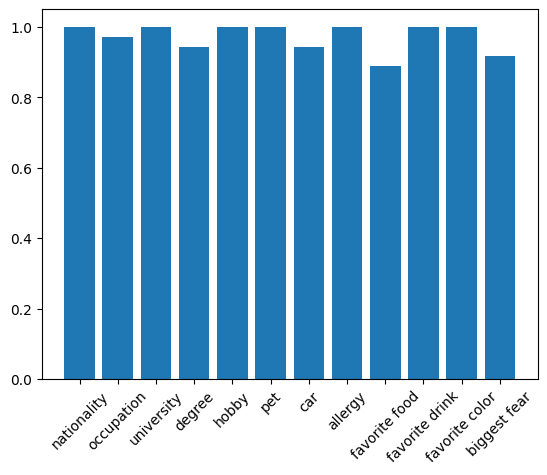

In [28]:
from matplotlib import pyplot as plt

plt.bar(
    acc_per_attribute.keys(),
    [acc_per_attribute[attr].mean for attr in acc_per_attribute],
)
plt.xticks(rotation=45)

plt.show()

In [35]:
atomic_eval_per_lm = {}

for eval_file in os.listdir(atomic_eval_save_dir):
    lm_size = eval_file.split("-")[1].split("_")[0]
    with open(os.path.join(atomic_eval_save_dir, eval_file), "r") as f:
        atomic_evals = json.load(f)
    atomic_eval_per_lm[lm_size] = get_acc_per_attribute(atomic_evals)

atomic_eval_per_lm.keys()

dict_keys(['14B', '4B', '8B'])

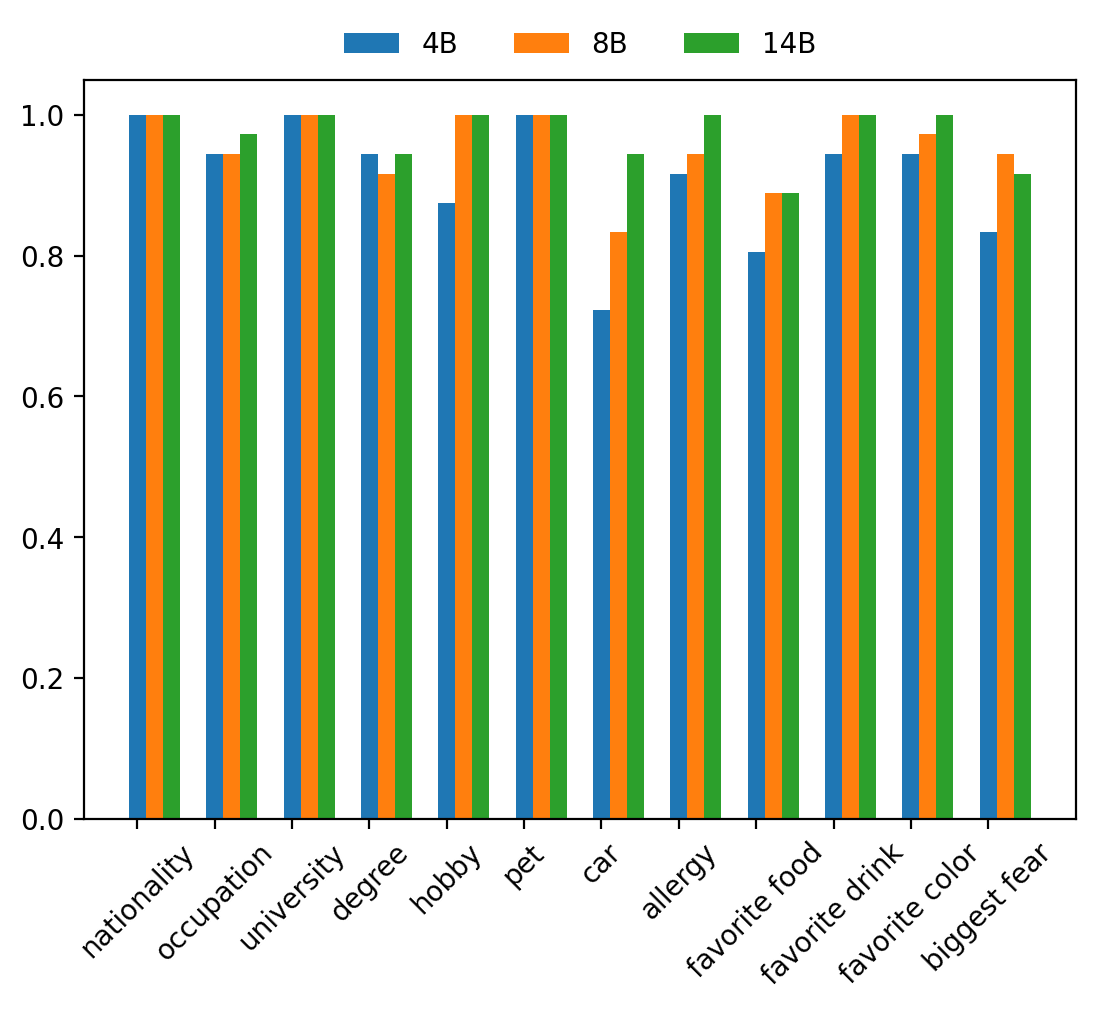

In [56]:
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200

lm_sizes = ["4B", "8B", "14B"]
keys = list(atomic_eval_per_lm[lm_sizes[0]].keys())

bar_width = 0.22
for idx, lm_size in enumerate(lm_sizes):
    acc_per_attribute = atomic_eval_per_lm[lm_size]
    plt.bar(
        x=[i + idx * bar_width for i in range(len(keys))],
        height=[acc_per_attribute[attr].mean for attr in acc_per_attribute],
        width=bar_width,
        label=lm_size,
    )

plt.xticks(ticks = list(range(len(keys))), labels = keys, rotation=45)
plt.legend(ncol=4, bbox_to_anchor=(0.5, 1.1), loc="upper center", frameon=False)
plt.show()

### Bi-Association Evaluation

In [6]:
SYNTH_DATASET = "icosahedron_1"

with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

In [78]:
from src.probing.prompt import BiAssociationPrefix
from src.probing.few_shot_examples import (
    human_nationality,
    human_profession,
    human_alma_mater,
    human_allergy,
    human_car,
    human_pet
)

prefix_generator_cls = BiAssociationPrefix

# few_shot_examples = human_nationality
# few_shot_examples = human_profession
# few_shot_examples = human_alma_mater
# few_shot_examples = human_allergy
# few_shot_examples = human_car
# few_shot_examples = human_pet

prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    # filter_attributes=[
    #     "nationality", 
    #     # "profession", 
    #     # "school"
    # ],
    format = "_3"
)

prefix = prefix_generator.get_prefix()
print(prefix)

# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"
4. Same hobby → "Yes - [hobby] - they both enjoy [hobby]"
5. Same pet → "Yes - [pet] - they both have a [pet] as their pet"
6. Same car → "Yes - [car] - they both drive a [car]"
7. Same allergy → "Yes - [allergy] - they are both allergic to [allergy]"
8. Same food → "Yes - [food] - they both love [food]"
9. Same drink → "Yes - [drink] - they both love [drink]"
10. Same color → "Yes - [color] - they both love [c

In [79]:
from src.utils.experiment_utils import set_seed
from src.utils.oracle_llms import ASK_ORACLE_MODEL
from typing import Literal
from src.functional import get_tick_marker, predict_next_token
from src.probing.utils import get_lm_generated_answer
from src.probing.prompt import prepare_probing_input

def verify_connection_with_oracle(
    lm_response: str,
    entity_profiles: tuple[dict] = None,
    oracle_model: Literal["claude", "gpt"] = "claude",
    expected_answer: str = None,
) -> str:
        
    instruction = f"""Check the following profiles of 2 people
```
profile_1: {json.dumps(entity_profiles[0], indent=2)}
```
```
profile_2: {json.dumps(entity_profiles[1], indent=2)}
```

A smaller LM was asked to find a connection between the two people. Any attribute these two people might share satisfies as a connection. If there is no connection, then the LM is expected to answer "None".

The LM's response is: \"{lm_response}\"
"""
    
    if expected_answer is not None:
        instruction += f"""The expected answer is: \"{expected_answer}\". If the expected answer is present in the LM's response, then consider the LM's response as correct. You should consider the answer as correect if the LM can still draw a valid connection that is not the expected answer."""

    instruction += """Please verify if the response is correct or not. Say "yes" if the response is correct and "no" if it is not.
Make sure to put your answer starts with either "yes" or "no".

Consider that the small LM's response might get abruptly cut off, due to the token limit. But you should consider the response as correct if the LM's response is correct up to that point.
"""
    response = ASK_ORACLE_MODEL[oracle_model](prompt=instruction, use_cache=True)
    logger.debug(f"oracle response: {response}")
    answer = response.lower().strip().startswith("yes")

    return answer

def get_connection_on_entity_pair(
    mt: ModelandTokenizer,
    entities: tuple[str],
    prefix_generator: BiAssociationPrefix,
    n_valid = 6,
    n_none = 2,
    enable_reasoning = False,
    return_next_token_probs = False,
    answer_prefix: str = ""
):
    prefix = prefix_generator.get_prefix(n_valid=n_valid, n_none=n_none)
    connection_prompt = prepare_probing_input(
        mt=mt,
        entities=(entities[0], entities[1]),
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=enable_reasoning,
        answer_prefix=answer_prefix,
    )
    print("\"" + mt.tokenizer.decode(connection_prompt.tokenized["input_ids"][0], skip_special_tokens=False) + "\"",)

    answer = get_lm_generated_answer(
        mt=mt, prompt=connection_prompt, 
        is_a_reasoning_model=enable_reasoning,
    )
    answer = answer.split("\n")[0]

    if return_next_token_probs:
        if enable_reasoning is False:
            return answer, predict_next_token(
                mt=mt, 
                inputs=connection_prompt.prompt,
                k=15
            )
        else:
            logger.warning("Next token probs are not meaningful for reasoning LMs. Will decode to <think> token always")
            return answer, None

    return answer

In [80]:
# REAL WORLD EXAMPLES
# query_entities = ["Michael Jackson", "Prince"] 
# query_entities = ("Abraham Lincoln", "John F. Kennedy")
# query_entities = ("John F. Kennedy", "Michael Jordan")
# query_entities = ("John F. Kennedy", "Bill Gates")
# query_entities = ("Charlie Chaplin", "Rowan Atkinson")
# query_entities = ["John Stewart", "Rowan Atkinson"]
# query_entities = ["Mahatma Gandhi", "Walt Disney"]
# query_entities = ["Stephen King", "H.P. Lovecraft"]
# query_entities = ["Marilyn Monroe", "Isaac Newton"]
# query_entities = ["Oprah Winfrey", "Ellen DeGeneres"]
# query_entities = ["Ada Lovelace", "Grace Hopper"]
# query_entities = ["Elon Musk", "Jeff Bezos"]
# query_entities = ["Johann Sebastian Bach", "Ludwig van Beethoven"]
# query_entities = ["Johann Sebastian Bach", "Karl Marx"]
# query_entities = ["Mads Mikkelsen", "Hugh Jackman"]
# query_entities = ["Mads Mikkelsen", "Nikolaj Coster-Waldau"]
# query_entities = ["Natalie Portman", "Emma Watson"]
# query_entities = ["Warren Buffett", "Casey Affleck"]
# query_entities = ["Tiger Woods", "Sergey Brin"]
# query_entities = ["Tiger Woods", "Bill Gates"]
# query_entities = ["Natalie Portman", "Bill Gates"]
# query_entities = ["Taylor Swift", "Freddie Mercury"]
query_entities = ["Taylor Swift", "Bill Gates"]
# query_entities = ["Mike Tyson", "Leonardo DiCaprio"]
# query_entities = ["John F. Kennedy", "Natalie Portman"]

# TEST
# query_entities = ["Thea Bridgeport", "Isabella Garcia"]
# query_entities = ["Elara Vance", "Briony Shaw"]
# query_entities = ["Elara Vance", "Declan Rivers"]
# query_entities = ["Elara Vance", "Aisha Patel"]
# query_entities = ["Ava Carter", "Alistair Finch"]
# query_entities = ["Ava Carter", "Sophia Davis"]
# query_entities = ["Declan Rivers", "Aisha Patel"]
# query_entities = ["Rajiv Kumar", "Aisha Patel"]
# query_entities = ["Declan Rivers", "Aiko Tanaka"]

# query_entities = ["Tariq Al-Mansour", "Declan Rivers"]
# query_entities = ["Ava Carter", "Sophia Davis"]
# query_entities = ["Elara Vance", "Rajiv Kumar"]
# query_entities = ["Isabella Garcia", "Rajiv Kumar"]
# query_entities = ["Rajiv Kumar", "Briony Shaw"]
# query_entities = ["Aiko Tanaka", "Michael Jordan"]
# query_entities = ["Elara Vance", "Alistair Finch"]
# query_entities = ["Alistair Finch", "Tariq Al-Mansour"]
# query_entities = ["Isolde Brackenridge", "Calista Norwick"]
# query_entities = ["Isolde Brackenridge", "Mirella Stonebridge"]
# query_entities = ["Thaddeus Elmworth", "Calista Norwick"]

# ICOSAHEDRON_1
# query_entities = ["Amara Vellon", "Eamon Thistledown"]
# query_entities = ["Eamon Thistledown", "Amara Vellon"]
# query_entities = ["Dorian Fairmont", "Orin Hawkwell"]
# query_entities = ["Zelena Rookwood", "Mirella Stonebridge"]

# query_entities = ["Lachlan Everfield", "Eamon Thistledown"]
# query_entities = ["Orin Hawkwell", "Bastian Crowther"]
# query_entities = ["Orin Hawkwell", "Mirella Stonebridge"]
# query_entities = ["Orin Hawkwell", "Zelena Rookwood"]
# query_entities = ["Soraya Bramble", "Amara Vellon"]
# query_entities = ["Thaddeus Elmworth", "Calista Norwick"]
# query_entities = ["Thaddeus Elmworth", "Dorian Fairmont"]
# query_entities = ["Soraya Bramble", "Eamon Thistledown"]
# query_entities = ["Calista Norwick", "Bastian Crowther"]

# REAL + SYNTH
# query_entities = ["Bastian Crowther", "Astrid Lindgren"]
# query_entities = ["Eamon Thistledown", "Hans Hass"]
# query_entities = ["Eamon Thistledown", "Gordon Ramsay"]
# query_entities = ["Amara Vellon", "Hans Hass"]
# query_entities = ["Thaddeus Elmworth", "Calista Norwick"]
# query_entities = ["Harvey Specter", "Orin Hawkwell"]
# query_entities = ["Harvey Specter", "Bastian Crowther"]

enable_reasoning = False
# enable_reasoning = True
# set_seed(142)
# connection_mt = mt_check
connection_mt = mt

connection, next_tok_probs = get_connection_on_entity_pair(
    mt=connection_mt,
    entities=query_entities,
    prefix_generator=prefix_generator,
    
    n_valid=0,
    n_none=0,
    enable_reasoning=enable_reasoning,
    return_next_token_probs=True,

    # answer_prefix=" Yes - they are both"
    answer_prefix = " Yes -"
    # answer_prefix = " No -"
)

logger.debug("-" * 150)
logger.info(f"({query_entities[0]}, {query_entities[1]}) => {connection}")
logger.debug("-" * 150)

# is_accurate = verify_connection_with_oracle(
#     lm_response=connection,
#     entity_profiles=(names_to_profiles[query_entities[0]], names_to_profiles[query_entities[1]]),
#     oracle_model="gpt",
# )
# logger.debug(f"({query_entities[0]}, {query_entities[1]}) => {get_tick_marker(is_accurate)}")

next_tok_probs

"# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"
4. Same hobby → "Yes - [hobby] - they both enjoy [hobby]"
5. Same pet → "Yes - [pet] - they both have a [pet] as their pet"
6. Same car → "Yes - [car] - they both drive a [car]"
7. Same allergy → "Yes - [allergy] - they are both allergic to [allergy]"
8. Same food → "Yes - [food] - they both love [food]"
9. Same drink → "Yes - [drink] - they both love [drink]"
10. Same color → "Yes - [color] - they both love [

[[PredictedToken(token=' [', prob=0.2734375, logit=20.875, token_id=508, metadata=None),
  PredictedToken(token=' United', prob=0.2412109375, logit=20.75, token_id=3639, metadata=None),
  PredictedToken(token=' same', prob=0.212890625, logit=20.625, token_id=1852, metadata=None),
  PredictedToken(token=' American', prob=0.1005859375, logit=19.875, token_id=3693, metadata=None),
  PredictedToken(token=' color', prob=0.041748046875, logit=19.0, token_id=1894, metadata=None),
  PredictedToken(token=' drink', prob=0.0224609375, logit=18.375, token_id=7027, metadata=None),
  PredictedToken(token=' music', prob=0.019775390625, logit=18.25, token_id=4627, metadata=None),
  PredictedToken(token=' hobby', prob=0.015380859375, logit=18.0, token_id=31528, metadata=None),
  PredictedToken(token=' nationality', prob=0.015380859375, logit=18.0, token_id=58243, metadata=None),
  PredictedToken(token=' Harvard', prob=0.01055908203125, logit=17.625, token_id=24951, metadata=None),
  PredictedToken(toke

#### Allowing more layers

In [81]:
from src.functional import predict_next_token, get_hs, logit_lens
from src.utils.typing import TokenizerOutput

prefix = prefix_generator.get_prefix(n_valid=10, n_none=1)
connection_prompt = prepare_probing_input(
    mt=connection_mt,
    entities=(query_entities[0], query_entities[1]),
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=enable_reasoning,
    answer_prefix=" Yes -",
)

# predict_next_token(
#     mt=connection_mt, 
#     inputs=connection_prompt.prompt,
#     k=15
# )

last_tok_states = get_hs(
    mt = connection_mt,
    input = TokenizerOutput(data = connection_prompt.tokenized),
    locations = [(mt.layer_name_format.format(l_idx), -1) for l_idx in range(mt.n_layer)],
    return_dict = True
)

logit_lens(
    mt = connection_mt,
    h = last_tok_states[(mt.layer_name_format.format(mt.n_layer - 1), -1)],
    k = 15
)

[PredictedToken(token=' Harvard', prob=0.85546875, logit=21.375, token_id=24951, metadata=None),
 PredictedToken(token=' Piano', prob=0.08984375, logit=19.125, token_id=55391, metadata=None),
 PredictedToken(token=' Guitar', prob=0.0201416015625, logit=17.625, token_id=46659, metadata=None),
 PredictedToken(token=' Music', prob=0.009521484375, logit=16.875, token_id=10717, metadata=None),
 PredictedToken(token=' Stanford', prob=0.00738525390625, logit=16.625, token_id=30688, metadata=None),
 PredictedToken(token=' Computer', prob=0.002899169921875, logit=15.6875, token_id=17407, metadata=None),
 PredictedToken(token=' Reading', prob=0.00145721435546875, logit=15.0, token_id=17769, metadata=None),
 PredictedToken(token=' Tennis', prob=0.00136566162109375, logit=14.9375, token_id=57151, metadata=None),
 PredictedToken(token=' Apple', prob=0.001068115234375, logit=14.6875, token_id=8162, metadata=None),
 PredictedToken(token=' Coding', prob=0.00093841552734375, logit=14.5625, token_id=480

In [82]:
for layer_idx in range(mt.n_layer):
    layer_name = mt.layer_name_format.format(layer_idx)
    h = last_tok_states[(layer_name, -1)]
    ll = logit_lens(
        mt=connection_mt,
        h=h,
        k=15,
    )
    ll_msg = [str(pred) for pred in ll]
    logger.debug(f"{layer_name} => {ll_msg}")

2025-05-27 14:02:39 __main__ DEBUG    model.layers.0 => ['"も多く"[141752] (p=0.613, logit=19.375)', '" معظم"[136700] (p=0.256, logit=18.500)', '"都有自己"[118755] (p=0.019, logit=15.875)', '"普遍存在"[117462] (p=0.013, logit=15.500)', '" المختلفة"[136973] (p=0.010, logit=15.250)', '"基本上都"[113850] (p=0.008, logit=15.062)', '"さまざまな"[140417] (p=0.007, logit=14.875)', '"様々な"[132433] (p=0.006, logit=14.750)', '",No"[85076] (p=0.006, logit=14.750)', '"人々"[137422] (p=0.005, logit=14.625)', '"克思"[103157] (p=0.004, logit=14.312)', '"世界各地"[110518] (p=0.004, logit=14.312)', '"หลายๆ"[139549] (p=0.003, logit=14.125)', '"为抓"[112981] (p=0.003, logit=14.125)', '"様々"[132432] (p=0.003, logit=13.875)']
2025-05-27 14:02:40 __main__ DEBUG    model.layers.1 => ['"も多く"[141752] (p=0.373, logit=17.875)', '" معظم"[136700] (p=0.226, logit=17.375)', '"さまざまな"[140417] (p=0.047, logit=15.812)', '"普遍存在"[117462] (p=0.037, logit=15.562)', '"都有自己"[118755] (p=0.032, logit=15.438)', '"様々"[132432] (p=0.029, logit=15.312)', '"許多"[106

In [83]:
from src.functional import PatchSpec, generate_with_patch

patches = [PatchSpec(
    location = (mt.layer_name_format.format(40), -1),
    patch = last_tok_states[(mt.layer_name_format.format(mt.n_layer-1), -1)],
)]

patched_generations = generate_with_patch(
    mt=connection_mt, 
    inputs=connection_prompt.prompt,
    max_new_tokens=80,
    # patches = patches,
    remove_prefix=True
)

print(json.dumps(
    patched_generations, 
    indent=2
))


predict_next_token(
    mt=connection_mt, 
    inputs=connection_prompt.prompt,
    k=15,
    # patches = patches,
)

[
  " Harvard University - they both graduated from Harvard University. \n\nNote: While Taylor Swift did attend Harvard for a semester, she did not graduate from there. However, for the purpose of this task, we'll assume the information provided is accurate. If you want to stick to factual accuracy, you can say:\n\nA: No - Taylor Swift and Bill Gates have nothing in common.",
  " Harvard University - they both graduated from Harvard University. \n\n(Note: While Taylor Swift attended Harvard for a semester and Bill Gates dropped out after two years, they both have a connection to Harvard University.) \n\nHowever, if we strictly consider graduation, the correct response would be:\n\nA: No - Taylor Swift and Bill Gates have nothing in common. \n\nFor the purpose of this task, let's assume the",
  " Harvard University - they both graduated from Harvard University. \n\n(Note: This is an example response. The actual response may vary based on the attributes provided for each person.) \n\nQ: 

[[PredictedToken(token=' Harvard', prob=0.85546875, logit=21.375, token_id=24951, metadata=None),
  PredictedToken(token=' Piano', prob=0.08984375, logit=19.125, token_id=55391, metadata=None),
  PredictedToken(token=' Guitar', prob=0.0201416015625, logit=17.625, token_id=46659, metadata=None),
  PredictedToken(token=' Music', prob=0.009521484375, logit=16.875, token_id=10717, metadata=None),
  PredictedToken(token=' Stanford', prob=0.00738525390625, logit=16.625, token_id=30688, metadata=None),
  PredictedToken(token=' Computer', prob=0.002899169921875, logit=15.6875, token_id=17407, metadata=None),
  PredictedToken(token=' Reading', prob=0.00145721435546875, logit=15.0, token_id=17769, metadata=None),
  PredictedToken(token=' Tennis', prob=0.00136566162109375, logit=14.9375, token_id=57151, metadata=None),
  PredictedToken(token=' Apple', prob=0.001068115234375, logit=14.6875, token_id=8162, metadata=None),
  PredictedToken(token=' Coding', prob=0.00093841552734375, logit=14.5625, to

#### Continue

In [41]:
from src.functional import generate_with_patch

# prompt_template = "{} is an employee of"
# prompt_template = "What is the nationality of {}? Ans:"
prompt_template = "What is the alma mater of {}? Ans:"
# prompt_template = "{} attended"
# prompt_template = "The biggest fear of {} is"
# prompt_template = "The nationality of {} is"
# prompt_template = "{} works as a"
# prompt_template = "What is the favorite food of {}? Ans"
# prompt_template = "{} is allergic to"
# prompt_template = "{} drives a"
# prompt_template = "{}'s pet is a"

# prompt_template = "Answer yes or no: does {} have a hobby of hiking? Ans:"

print(json.dumps(
    generate_with_patch(
        mt=connection_mt,
        inputs=prompt_template.format(query_entities[0]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=connection_mt,
        inputs=prompt_template.format(query_entities[1]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

[
  "What is the alma mater of Warren Buffett? Ans: Warren Buffett, the renowned American business magnate, investor, and philanthropist, attended the University of Pennsylvania for his undergraduate studies. However, he"
]
[
  "What is the alma mater of Casey Affleck? Ans: Casey Affleck's alma mater is Harvard University. Casey Affleck attended Harvard University, but it is not officially documented that he graduated from there. He"
]


## Bi-association Localization Check

In [49]:
# common_entity = "Ava Carter"
# clean_entity = "Alistair Finch"
# patch_entity = "Sophia Davis"

# clean_entity, patch_entity = patch_entity, clean_entity

# connection_mt = mt_check
connection_mt = mt

common_entity = "Ryan Reynolds"
clean_entity = "Celine Dion"
patch_entity = "Tom Cruise"

set_seed(42)
prefix_generator = BiAssociationPrefix()
prefix = prefix_generator.get_prefix(n_valid=10, n_none=2)

kwargs = dict(
    mt = connection_mt,
    prefix = prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix="Yes - they are both",
)

clean_prompt = prepare_probing_input(
    entities=(clean_entity, common_entity),
    **kwargs,
)

clean_answer = get_lm_generated_answer(
    mt = connection_mt,
    prompt = clean_prompt,
    is_a_reasoning_model=False,
)
logger.info(f"{clean_entity} <> {common_entity} => {clean_answer=}")

patch_prompt = prepare_probing_input(
    entities=(patch_entity, common_entity),
    **kwargs,
)
patch_answer = get_lm_generated_answer(
    mt = connection_mt,
    prompt = patch_prompt,
    is_a_reasoning_model=False,
)
logger.info(f"{patch_entity} <> {common_entity} => {patch_answer=}")

2025-05-21 14:26:24 src.utils.experiment_utils INFO     setting all seeds to 42


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-05-21 14:26:30 __main__ INFO     Celine Dion <> Ryan Reynolds => clean_answer='Canadian.'
2025-05-21 14:26:36 __main__ INFO     Tom Cruise <> Ryan Reynolds => patch_answer='actors.'


In [51]:
prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")
from src.tokens import align_patching_positions

aligned = align_patching_positions(
    mt=connection_mt,
    prompt_template=prompt_template,
    clean_subj=clean_entity,
    patched_subj=patch_entity,
    # trace_start_marker=".",
)

print(aligned["clean_input"].input_ids.shape, aligned["patched_input"].input_ids.shape)

torch.Size([1, 589]) torch.Size([1, 589])


In [53]:
from src.functional import predict_next_token
from src.utils.typing import TokenizerOutput

predict_next_token(
    mt = connection_mt,
    inputs = aligned["clean_input"]
)

[[PredictedToken(token=' Canadian', prob=0.9921875, logit=25.5, token_id=12152, metadata=None),
  PredictedToken(token=' Canadians', prob=0.004608154296875, logit=20.125, token_id=36262, metadata=None),
  PredictedToken(token=' allergic', prob=0.00115966796875, logit=18.75, token_id=57596, metadata=None),
  PredictedToken(token=' canadian', prob=0.000705718994140625, logit=18.25, token_id=88698, metadata=None),
  PredictedToken(token=' from', prob=0.0002593994140625, logit=17.25, token_id=505, metadata=None)]]

In [54]:
predict_next_token(
    mt = connection_mt,
    inputs = aligned["patched_input"]
)

[[PredictedToken(token=' actors', prob=0.89453125, logit=23.5, token_id=20142, metadata=None),
  PredictedToken(token=' American', prob=0.07373046875, logit=21.0, token_id=3778, metadata=None),
  PredictedToken(token=' Canadian', prob=0.0185546875, logit=19.625, token_id=12152, metadata=None),
  PredictedToken(token=' allergic', prob=0.0025177001953125, logit=17.625, token_id=57596, metadata=None),
  PredictedToken(token=' american', prob=0.002227783203125, logit=17.5, token_id=39542, metadata=None)]]

===> trace_start_idx=572
2025-05-21 14:27:23 src.trace DEBUG    answer=PredictedToken(token=' actors', prob=0.89453125, logit=23.5, token_id=20142, metadata=None)
2025-05-21 14:27:24 src.trace DEBUG    clean_answer=PredictedToken(token=' Canadian', prob=0.9921875, logit=25.5, token_id=12152, metadata=None)
2025-05-21 14:27:24 src.trace DEBUG    track_ans=PredictedToken(token=' actors', prob=4.792213439941406e-05, logit=15.5625, token_id=20142, metadata=None)
2025-05-21 14:27:24 src.trace DEBUG    base_score=23.5 | low_score=15.5625
2025-05-21 14:27:24 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 1360/1360 [11:21<00:00,  2.00it/s]

2025-05-21 14:38:45 src.trace INFO     base_score=23.5 | low_score=15.5625
2025-05-21 14:38:45 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-21 14:38:45 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-21 14:38:45 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2025-05-21 14:38:45 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-21 14:38:45 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu 

2025-05-21 14:38:46 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/tlwg/Umpush-Bold.otf', name='Umpush', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-05-21 14:38:46 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansTelugu-Bold.ttf', name='Noto Sans Telugu', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-05-21 14:38:46 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/stix/STIXNonUnicode-Italic.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-05-21 14:38:46 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Chilanka-Regular.otf', name='Chilanka', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

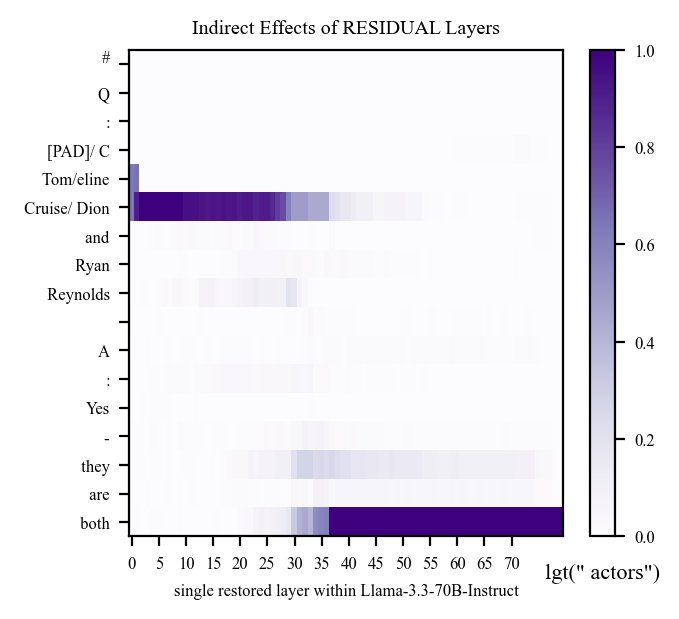

===> trace_start_idx=572
2025-05-21 14:38:48 src.trace DEBUG    answer=PredictedToken(token=' actors', prob=0.89453125, logit=23.5, token_id=20142, metadata=None)
2025-05-21 14:38:48 src.trace DEBUG    clean_answer=PredictedToken(token=' Canadian', prob=0.9921875, logit=25.5, token_id=12152, metadata=None)
2025-05-21 14:38:48 src.trace DEBUG    track_ans=PredictedToken(token=' actors', prob=4.792213439941406e-05, logit=15.5625, token_id=20142, metadata=None)
2025-05-21 14:38:48 src.trace DEBUG    base_score=23.5 | low_score=15.5625
2025-05-21 14:38:48 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 1360/1360 [11:23<00:00,  1.99it/s]

2025-05-21 14:50:11 src.trace INFO     base_score=23.5 | low_score=15.5625
2025-05-21 14:50:11 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7eda230605d0>
2025-05-21 14:50:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-21 14:50:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-21 14:50:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


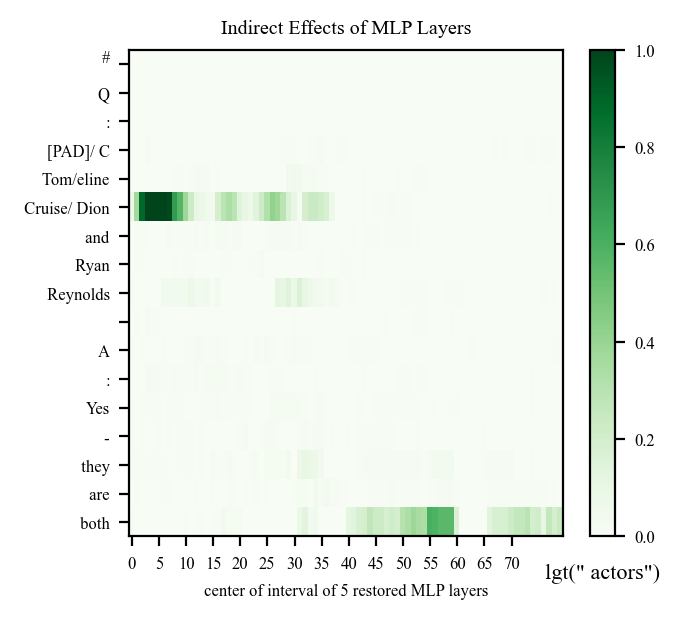

===> trace_start_idx=572
2025-05-21 14:50:13 src.trace DEBUG    answer=PredictedToken(token=' actors', prob=0.89453125, logit=23.5, token_id=20142, metadata=None)
2025-05-21 14:50:13 src.trace DEBUG    clean_answer=PredictedToken(token=' Canadian', prob=0.9921875, logit=25.5, token_id=12152, metadata=None)
2025-05-21 14:50:13 src.trace DEBUG    track_ans=PredictedToken(token=' actors', prob=4.792213439941406e-05, logit=15.5625, token_id=20142, metadata=None)
2025-05-21 14:50:13 src.trace DEBUG    base_score=23.5 | low_score=15.5625
2025-05-21 14:50:13 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 1360/1360 [11:23<00:00,  1.99it/s]

2025-05-21 15:01:36 src.trace INFO     base_score=23.5 | low_score=15.5625
2025-05-21 15:01:36 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7eda2309fd50>
2025-05-21 15:01:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-21 15:01:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-21 15:01:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


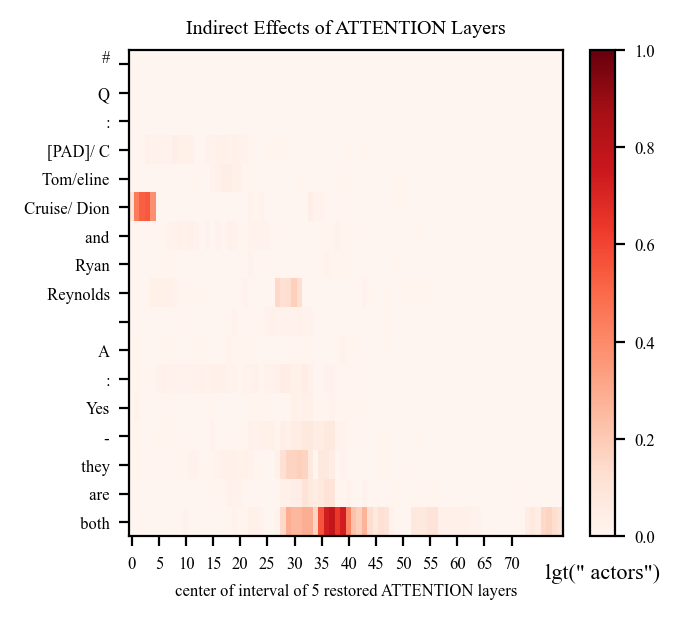

In [56]:
from src.trace import trace_important_states
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
# for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=connection_mt,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        # clean_input=TokenizerOutput(data=clean_prompt.tokenized),
        # patched_input=TokenizerOutput(data=patch_prompt.tokenized),
        trace_start_marker="#",

        metric="logit",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized is True else None,
    )

In [5]:
mt

NameError: name 'mt' is not defined

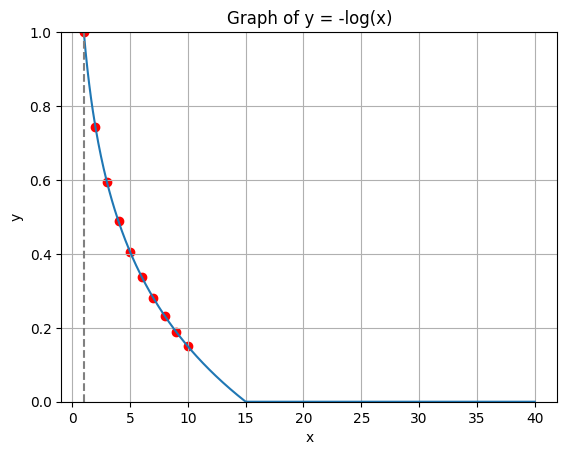

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
ranks = np.linspace(1, 40, 500) # Start slightly above 0 to avoid log(0)

# Calculate corresponding y values
def reward(rank, k=15):
    buffer = np.log(k)
    y = (-np.log(rank) + buffer) / buffer
    y = np.clip(y, 0, None)
    return y

y = reward(ranks)

# Create the plot
plt.plot(ranks, y)
plt.scatter(
    list(range(1, 11)),
    [reward(i) for i in range(1, 11)],
    color='red',
)

plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Graph of y = -log(x)")
plt.grid(True)
plt.axvline(x=1, color='gray', linestyle='--') # Show the vertical asymptote
plt.show()

In [142]:
t = torch.Tensor([3,1,4,6,7,12,8,9,2])[None]
# t.topk(k=t.shape[-1], dim=-1, largest=True, sorted=True)
t.argsort(dim=-1, descending=True)

tensor([[5, 7, 6, 4, 3, 2, 0, 8, 1]])